In [32]:
import math
import sys
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import torch.nn as nn
import argparse
from scipy.stats import zscore
import torch
import matplotlib.pyplot as plt # For visualization, not part of the core function


INIT_SEED = 222

def gpr_dot_product_explicit(train_x, train_y, test_x, noise_var):
    """
    Computes Gaussian Process Regression mean and standard deviation using explicit formulas
    with a Dot Product Kernel.

    Args:
        train_x (torch.Tensor): N_train x D tensor of training input features.
        train_y (torch.Tensor): N_train x 1 tensor of training target values.
        test_x (torch.Tensor): N_test x D tensor of test input features.
        sigma_0_sq (float or torch.Tensor): The sigma_0^2 hyperparameter for the DotProduct kernel.
                                            This is NOT trained, you provide its value.
        noise_var (float or torch.Tensor): The observational noise variance (added to diagonal).
                                           This is NOT trained, you provide its value.

    Returns:
        tuple: (mu_pred, sigma_pred)
            mu_pred (torch.Tensor): N_test x 1 tensor of predicted means.
            sigma_pred (torch.Tensor): N_test x 1 tensor of predicted standard deviations.
    """

    # Ensure hyperparameters are tensors and on the correct device
    # This makes the function flexible to accept floats or pre-existing tensors
    sigma_0_sq = torch.tensor(sigma_0_sq, dtype=torch.float32, device=train_x.device)
    noise_var = torch.tensor(noise_var, dtype=torch.float32, device=train_x.device)

    # 1. Define the DotProduct kernel function (helper within the main function)
    def dot_product_kernel_torch(X1, X2, sigma_0_sq_param):
        """
        Computes the DotProduct kernel matrix K(X1, X2) using PyTorch.
        k(xi, xj) = xi @ xj.T
        """
        return X1 @ X2.T

    K_xx = dot_product_kernel_torch(train_x, train_x) + noise_var * torch.eye(train_x.shape[0], device=train_x.device)

    K_xstar_x = dot_product_kernel_torch(test_x, train_x, sigma_0_sq)

    K_xstar_xstar = dot_product_kernel_torch(test_x, test_x, sigma_0_sq)

    jitter = 1e-6 * torch.eye(train_x.shape[0], device=train_x.device)
    try:
        K_xx_inv = torch.linalg.inv(K_xx + jitter)
    except torch.linalg.LinAlgError as e:
        print(f"Error: K_xx is singular or ill-conditioned even with jitter: {e}")
        raise

    # 4. Predict Mean (mu_pred)
    # Formula: mu_pred = K(X_test, X_train) @ K(X_train, X_train)^-1 @ y_train
    mu_pred = K_xstar_x @ K_xx_inv @ train_y

    return mu_pred

class FCN_2_layers(nn.Module):
      def __init__(self, d,N,init_out,init_hidden,activation, init_seed=None):
        super().__init__()
        if init_seed is not None:
            torch.manual_seed(INIT_SEED)
        self.lin1 = nn.Linear(d,N, bias=False)
        self.lin2 = nn.Linear(N,1, bias=False)
        self.activation=activation
        self.N = N
        self.d = d
        #np.random.seed(5)
        nn.init.normal_(self.lin1.weight,0,(init_hidden)**0.5)
        nn.init.normal_(self.lin2.weight,0,(init_out)**0.5)

      def forward(self, x):
        x = self.lin1(x)

        res = self.lin2(torch.flatten(x, start_dim=1))
        return res


def activation(x):
    return x

current_dir = os.path.abspath('')
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

#   # I trained one network per set of hyperparameters
#   def find_net0_files_os_walk(parent_dir):
#       found_files = []
#       for root, dir, files in os.walk(parent_dir):
#           for file in files:
#               if file == 'netnum_0':  # Or 'net₀' if that's the exact character
#                   found_files.append(os.path.join(root, file))
#       return found_files

def find_net0_files_os_walk(fname, base_dir: str = "gptnettrain"):
    """
    Finds files named 'netnum_0' within subdirectories of a base directory
    (defaulting to 'gptnettrain') that start with 'network_ensemble_300000'.

    Args:
        base_dir (str): The base directory to start the search from (e.g., 'gptnettrain').

    Returns:
        list[str]: A list of full paths to all found 'netnum_0' files
                   that meet the specified subdirectory condition.
                   Returns an empty list if the base directory does not exist
                   or no such files are found.
    """
    found_files = []
    target_subdir_prefix = fname

    if not os.path.isdir(base_dir):
        print(f"Error: The base directory '{base_dir}' does not exist.")
        return []

    # First, identify the direct subdirectories that match the prefix
    qualifying_subdirs = []
    try:
        for entry in os.listdir(base_dir):
            full_path = os.path.join(base_dir, entry)
            if os.path.isdir(full_path) and entry.startswith(target_subdir_prefix):
                qualifying_subdirs.append(full_path)
    except OSError as e:
        print(f"Error accessing directory '{base_dir}': {e}")
        return []

    if not qualifying_subdirs:
        print(f"No subdirectories starting with '{target_subdir_prefix}' found directly under '{base_dir}'.")
        return []

    # Now, walk through each of these specific subdirectories
    for subdir_to_explore in qualifying_subdirs:
        for root, _, files in os.walk(subdir_to_explore):
            for filename in files:
                if filename.startswith("netnum_"):
                    full_path = os.path.join(root, filename)
                    found_files.append(full_path)

    return found_files


def get_data(d,n,seed):
    np.random.seed(seed)
    X = torch.tensor(np.random.normal(loc=0,scale=1.,size=(n,1,d))).to(dtype=torch.float32)
    return X


train_seed = 563

theory_eigs_path = './theory_eigs.json'


def run(fname):
    Menagerie_dir = os.path.join('/home/akiva/gpnettrain')
    theory = None
    with open(theory_eigs_path,'r') as f:
        theory = json.load(f)
    lH_diffs = []
    nets = find_net0_files_os_walk(fname, Menagerie_dir)
    nets = sorted(nets, key=lambda x: os.path.getctime(x))
    eigs = []
    Kemp_thr_ratios = []
    Kstd = []
    Ns = []

    dats=[]
    """
       dats: [ 
       {N:
        ratios}
    ]
    """
    print(f'{len(nets)} nets identified. Loading now....')
    for i in range(len(nets)): 
        # print(f'Loading net {i} @ {nets[i]}')
        n = torch.load(nets[i], map_location=torch.device('cpu'))

        
        W1 = n.lin1.weight.detach()
        P = 30
        N = W1.shape[0]
        d = W1.shape[1]

        X = get_data(d, N, train_seed) #.to('cuda') # this is the train seed used in net.py
        X = X.squeeze()
        W1 = n.lin1.weight.detach()

        f = (X @ W1.T)
        fm = torch.mean(f, dim=1)
        hh = torch.einsum('ji,ki->jk', f, f)/N #- np.einsum('j,k->jk', fm,fm)
        real_hh = torch.einsum('ui,vi->uv',X,X)/d
        torch.set_printoptions(precision=3, sci_mode=False)
        a0 = hh.flatten()
        b0 = real_hh.flatten()
        krat = (a0/b0)
        kdiff = (a0-b0)
        # krat = krat[np.abs(zscore(krat)) < 1.5]
        krat = krat
        Ls = torch.einsum('uj,uv,vj->j', X, hh, X) / N
        norm = torch.einsum('ij,ij->j',X, X) / N
        ls = (Ls/norm).cpu()
        # eigs.append(ls)

        dats.append({'width':N,
                     'ratio_mean': krat.mean(), 
                     'ratio_std': krat.std(),
                     'eig': ls,
                    'diff_mean': kdiff.mean(),
                    'diff_std': kdiff.std()})


#       theorylHp = float(theory["perps"][i][1])
#       theorylHT = float(theory["targ"][i][1])
#       lH_diff = ls[0] - theorylHp
#       lH_diffs.append(lH_diff)
#       print(f'P: {P}, N:{N}, d:{d}')
#       print(f'Emp   : {np.mean(ls): .4f}, std: {np.std(ls): .4f}')
#       print(f'Theory: {(1/d): .4f}')
#       print(f'FLT   : {theorylHT: .4f}')
#       print(f'FLp   : {theorylHp: .4f}')
#       print(f'Diff  : {lH_diff: .4f}')
#       print("------------------------")
#
        # What do I actually want to compute?
        # The centering of the eigenvalues around 
        # their expected value, as P, N, d grow
#   print(lH_diffs)
    return dats 
    

In [33]:
dats

[{'width': 40,
  'ratio_mean': tensor(0.862),
  'ratio_std': tensor(3.430),
  'eig': tensor([13.549, 19.159,  8.156]),
  'diff_mean': tensor(0.862),
  'diff_std': tensor(3.430)},
 {'width': 200,
  'ratio_mean': tensor(1.414),
  'ratio_std': tensor(38.046),
  'eig': tensor([75.334, 69.205, 64.390]),
  'diff_mean': tensor(1.414),
  'diff_std': tensor(38.046)},
 {'width': 800,
  'ratio_mean': tensor(0.958),
  'ratio_std': tensor(26.090),
  'eig': tensor([267.950, 290.554, 285.286]),
  'diff_mean': tensor(0.958),
  'diff_std': tensor(26.090)},
 {'width': 4000,
  'ratio_mean': tensor(0.976),
  'ratio_std': tensor(81.091),
  'eig': tensor([1353.051, 1332.233, 1320.489]),
  'diff_mean': tensor(0.976),
  'diff_std': tensor(81.091)},
 {'width': 130,
  'ratio_mean': tensor(1.043),
  'ratio_std': tensor(5.316),
  'eig': tensor([46.576, 37.205, 48.532]),
  'diff_mean': tensor(1.043),
  'diff_std': tensor(5.316)},
 {'width': 2000,
  'ratio_mean': tensor(0.665),
  'ratio_std': tensor(522.882),
  'ei

In [34]:
dats = run('fcn2_FL_20250619_145308')

210 nets identified. Loading now....


/tmp/ipykernel_3765153/4009925748.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  n = torch.load(nets[i], map_location=torch.device('cpu'))


In [9]:
dats

[{'width': 40,
  'ratio_mean': tensor(0.862),
  'ratio_std': tensor(3.430),
  'eig': tensor([13.549, 19.159,  8.156]),
  'diff_mean': tensor(0.862),
  'diff_std': tensor(3.430)},
 {'width': 200,
  'ratio_mean': tensor(1.414),
  'ratio_std': tensor(38.046),
  'eig': tensor([75.334, 69.205, 64.390]),
  'diff_mean': tensor(1.414),
  'diff_std': tensor(38.046)},
 {'width': 800,
  'ratio_mean': tensor(0.958),
  'ratio_std': tensor(26.090),
  'eig': tensor([267.950, 290.554, 285.286]),
  'diff_mean': tensor(0.958),
  'diff_std': tensor(26.090)},
 {'width': 4000,
  'ratio_mean': tensor(0.976),
  'ratio_std': tensor(81.091),
  'eig': tensor([1353.051, 1332.233, 1320.489]),
  'diff_mean': tensor(0.976),
  'diff_std': tensor(81.091)},
 {'width': 130,
  'ratio_mean': tensor(1.043),
  'ratio_std': tensor(5.316),
  'eig': tensor([46.576, 37.205, 48.532]),
  'diff_mean': tensor(1.043),
  'diff_std': tensor(5.316)},
 {'width': 2000,
  'ratio_mean': tensor(0.665),
  'ratio_std': tensor(522.882),
  'ei

In [76]:
def processdats(dats):
    ratio_means = {}
    ratio_stds = {}
    
    diff_means = {}
    diff_stds = {}
    
    all_eigs = {}
    
    for d in dats:
        n = d['width']
        km = d['ratio_mean'].tolist()
        ks = d['ratio_std'].tolist()
    
        Dm = d['diff_mean'].tolist()
        Ds = d['diff_std'].tolist()
        if not n in all_eigs:
            all_eigs[n] = d['eig'].tolist()
        else:
            all_eigs[n].extend(d['eig'])
        
        if not n in ratio_means:
            ratio_means[n] = [km]
            ratio_stds[n] = [km]
        else: 
            ratio_means[n].append(km)
            ratio_stds[n].append(ks)
    
        if not n in diff_means:
            diff_means[n] = [Dm]
            diff_stds[n]= [Ds]
        else: 
            diff_means[n].append(Dm)
            diff_stds[n].append(Ds)
    
    def stdstd(xs):
        return np.sqrt(np.mean(np.array(xs)**2))
        
    Ns = np.array([i for i in ratio_means.keys()])
    kkm = [np.mean(i) for k,i in ratio_means.items()]
    kks = [stdstd(i) for k,i in ratio_stds.items()]
    Dkm = np.array([np.mean(i) for k,i in diff_means.items()])
    Dks = np.array([stdstd(i) for k,i in diff_stds.items()])

    return Ns, kkm, kks, Dkm, Dks

In [106]:
smalldats = run('fcn2_FL_20250619_121049')

21 nets identified. Loading now....


/tmp/ipykernel_3765153/4009925748.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  n = torch.load(nets[i], map_location=torch.device('cpu'))


In [141]:
def kkrender(dats,ens):
    Ns, kkm, kks, Dkm, Dks = dats
    # plt.figure()
    plt.scatter(np.log10(Ns), np.log10(np.array(kks)**2), label=f'{ens} ensemble')
    plt.xlabel('$\log N$')
    plt.ylabel('$\log\sigma^2_{\hat{K}/K}$')
    plt.title(f'd:3 P:30'+'– $\sigma_{\\hat{K}/K}$ loglog')
    plt.legend()
    # plt.figure()
    # plt.scatter(np.log10(Ns), np.log10(np.array(Dks)**2), label=f'{ens} ensemble')
    # plt.xlabel('$\log N$')
    # plt.ylabel('$\log\sigma^2_{\hat{K} - K}$')
    # plt.title("log $\sigma^2_{\hat{K} - K}$ against log N (width) ")
    # plt.legend()
    # Create the plot with error bars
    # plt.figure()
    # plt.scatter(Ns, Dkm)    
    # plt.errorbar(Ns, Dkm, yerr=Dks, fmt='o', capsize=4, label='Kernel Ratio')
    
    # for i, txt in enumerate(kkm):
    #     plt.text(Ns[i], Dkm[i]+Dks[i], f'({Ns[i]}, {Dkm[i]:.2f})', color='black', ha='center', va='bottom', fontsize=8)
    # # Add labels and title for clarity
    # plt.xlabel("N (width)")
    # plt.ylabel("Diff $K_{uv}$ Exp-Theory")
    # plt.title( f'Ensemble of {len(dats)} FCN2s @ 30/N On Data | d:3 P:30 | '+ '$\hat{K}_{uv}-K^t_{uv}$')
    # plt.legend()
    # plt.tight_layout()

def dkrender(dats,ens):
    Ns, kkm, kks, Dkm, Dks = dats
    # plt.figure()
    plt.scatter(np.log10(Ns), np.log10(np.array(Dks)**2), label=f'{ens} ensemble')
    plt.xlabel('$\log N$')
    plt.ylabel('$\log\sigma^2_{\hat{K} - K}$')
    plt.title("log $\sigma^2_{\hat{K} - K}$ against log N (width) ")
    plt.legend()

def pl(dats,ens):
        # Create the plot with error bars
    Ns, kkm, kks, Dkm, Dks = dats
    plt.scatter(Ns, Dkm)    
    plt.errorbar(Ns, Dkm, yerr=Dks, fmt='o', capsize=4, label=f'{ens} ensemble')
    
    for i, txt in enumerate(kkm):
        plt.text(Ns[i], Dkm[i]+Dks[i], f'({Ns[i]}, {Dkm[i]:.2f})', color='black', ha='center', va='bottom', fontsize=8)
    # Add labels and title for clarity
    plt.xlabel("N (width)")
    plt.ylabel("Diff $K_{uv}$ Exp-Theory")
    plt.title( f'Ensemble of {len(dats)} FCN2s @ 30/N On Data | d:3 P:30 | '+ '$\hat{K}_{uv}-K^t_{uv}$')
    plt.legend()
    plt.tight_layout()

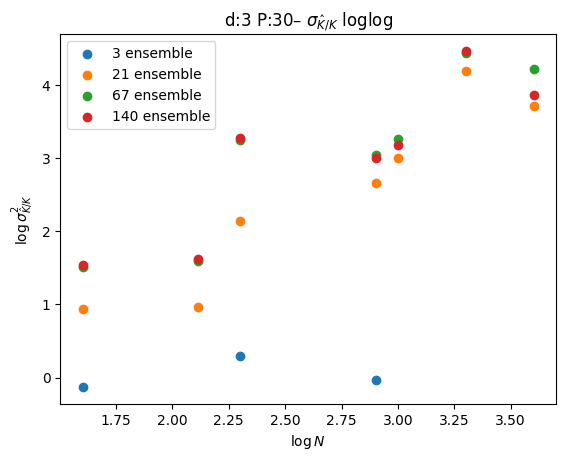

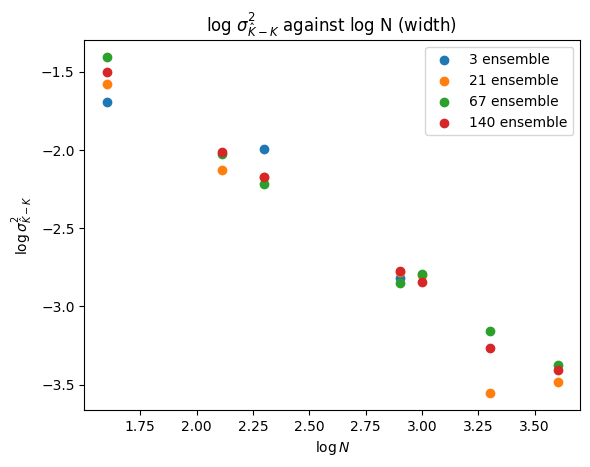

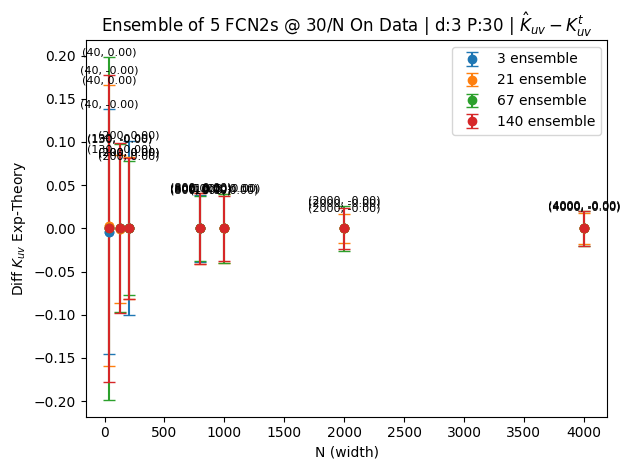

In [142]:
microdats = dats[:3]
middats = dats[3:70]
largdats = dats[70:210]
plt.figure()
kkrender(processdats(microdats), len(microdats))
kkrender(processdats(smalldats), len(smalldats))
kkrender(processdats(middats), len(middats))
kkrender(processdats(largdats), len(largdats))

plt.figure()
dkrender(processdats(microdats), len(microdats))
dkrender(processdats(smalldats), len(smalldats))
dkrender(processdats(middats), len(middats))
dkrender(processdats(largdats), len(largdats))

plt.figure()
pl(processdats(microdats), len(microdats))
pl(processdats(smalldats), len(smalldats))
pl(processdats(middats), len(middats))
pl(processdats(largdats), len(largdats))

21 nets identified. Loading now....


/tmp/ipykernel_3765153/4009925748.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  n = torch.load(nets[i], map_location=torch.device('cpu'))


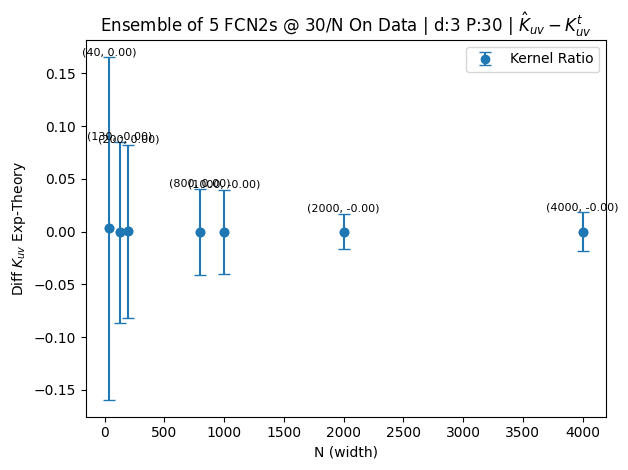

Text(0.5, 1.0, 'log $\\sigma^2_{\\hat{K}/K}$ against log N (width) ')

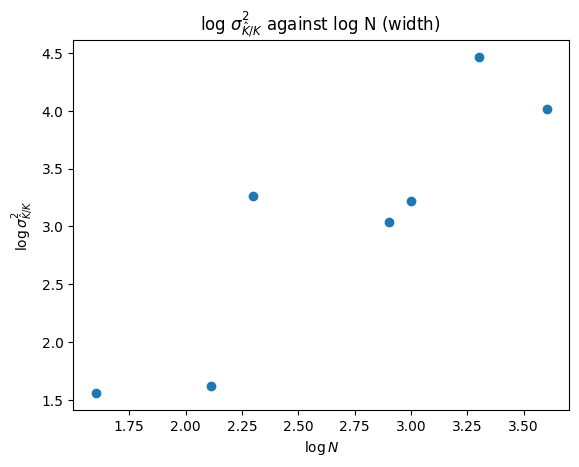

Text(0.5, 1.0, 'log $\\sigma^2_{\\hat{K} - K}$ against log N (width) ')

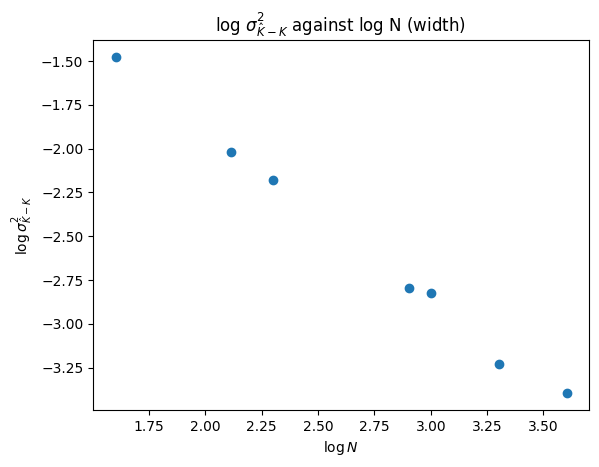

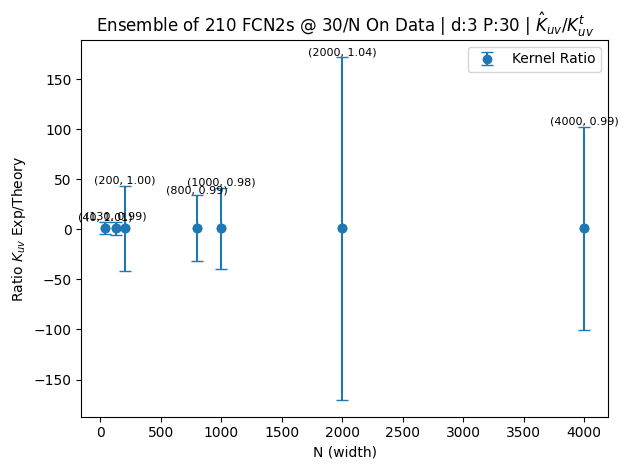

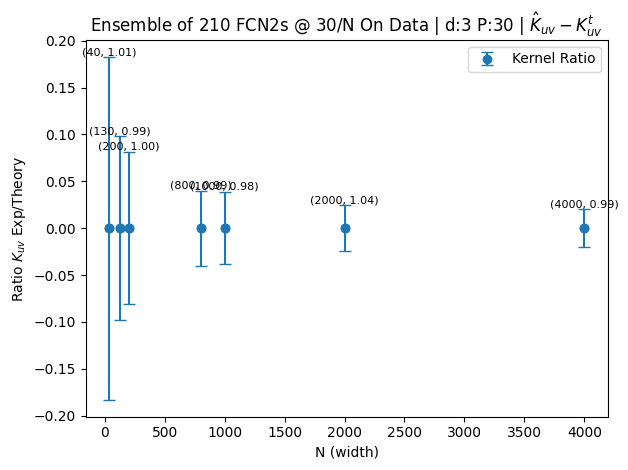

In [68]:
# Create the plot with error bars
plt.figure()
plt.scatter(Ns, Dkm)    
plt.errorbar(Ns, Dkm, yerr=Dks, fmt='o', capsize=4, label='Kernel Ratio')

for i, txt in enumerate(kkm):
    plt.text(Ns[i], Dkm[i]+Dks[i], f'({Ns[i]}, {kkm[i]:.2f})', color='black', ha='center', va='bottom', fontsize=8)
# Add labels and title for clarity
plt.xlabel("N (width)")
plt.ylabel("Ratio $K_{uv}$ Exp/Theory")
plt.title( f'Ensemble of {len(dats)} FCN2s @ 30/N On Data | d:3 P:30 | '+ '$\hat{K}_{uv}-K^t_{uv}$')
plt.legend()
plt.tight_layout()

In [2]:
import pickle

filename = 'fcn2_FL_20250619_145308.pkl' # Assuming a .pkl extension

try:
    with open(filename, 'rb') as file:
        loaded_data = pickle.load(file)
    print(f"File '{filename}' loaded successfully.")
    # print(loaded_data) # Uncomment to see the loaded content
except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found.")
except pickle.UnpicklingError:
    print(f"Error: Could not unpickle the file. It might be corrupted or not a valid pickle file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File 'fcn2_FL_20250619_145308.pkl' loaded successfully.


In [5]:
loaded_data[0]

{'width': 40,
 'ratio': [0.8174805045127869,
  0.6119250655174255,
  0.9324381351470947,
  0.024454178288578987,
  1.0646438598632812,
  -0.279601126909256,
  1.056313157081604,
  1.5128129720687866,
  0.8524515628814697,
  1.2128689289093018,
  -1.497856616973877,
  0.8913251161575317,
  0.7269266843795776,
  0.6484047770500183,
  0.23933009803295135,
  0.8159253001213074,
  0.2513439655303955,
  0.5427106618881226,
  0.7616426348686218,
  0.7093773484230042,
  -0.3829112648963928,
  1.2822715044021606,
  1.6758674383163452,
  0.6976349353790283,
  -0.1196657121181488,
  0.6342417001724243,
  2.9596645832061768,
  0.326060026884079,
  0.9756478667259216,
  0.7544496059417725,
  2.066257953643799,
  1.1937434673309326,
  1.2883654832839966,
  1.031617522239685,
  1.919158697128296,
  0.7707246541976929,
  0.7042134404182434,
  1.1569381952285767,
  0.6995953321456909,
  0.8310878872871399,
  0.6119250655174255,
  0.8925784230232239,
  4.03147554397583,
  1.3286961317062378,
  1.2707242